## To Start, we scrape the Wikipedia list of Netlix Original Films

### Scrape the page from "https://en.wikipedia.org/wiki/Special:Export/List_of_Netflix_original_films" 

##### We will scrape this with urllib and use BeautifulSoup to parse the resulting XML

In [2]:
import urllib.request
url = "https://en.wikipedia.org/wiki/List_of_Netflix_original_films"
page = urllib.request.urlopen(url)

In [3]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(page, 'lxml')

In [4]:
#let's take a look at this
print(soup.title.string)
print(soup.prettify())

List of Netflix original films - Wikipedia
<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of Netflix original films - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"f8547e1a-f809-43f4-9a3f-a4c1a6794c97","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_Netflix_original_films","wgTitle":"List of Netflix original films","wgCurRevisionId":979429593,"wgRevisionId":979429593,"wgArticleId":56312051,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["CS1 maint: numeric names: authors list","Cite tweet temp

In [5]:
#The interesting parts are 'wikitable sortable' tables, let's get that section
all_tables = soup.find_all("table", class_="wikitable sortable")
#There are a few tables in this page, let's get the first one
table=all_tables[0]

In [8]:
#now we loop through the rows to extract the data, maybe there's a better way to do this...
import pandas as pd

filmdata = pd.DataFrame(columns=['Title','Date'])
#use the HTML tags to identify rows and split up the cells

for row in table.findAll('tr'):
    cells = row.findAll('td')
    #if the row is complete (i.e. contains all entries), then pull the data
    #I only care about the first three entries: Title, Genre, Premiere Date
    if len(cells)==5:
        filmdata.loc[len(filmdata)] = [(cells[0].find(text=True)).lower(),cells[2].find(text=True)]
filmdata.head()

,Title,Date
0,beasts of no nation,"October 16, 2015"
1,the ridiculous 6,"December 11, 2015"
2,"crouching tiger, hidden dragon: sword of destiny","February 26, 2016"
3,pee-wee's big holiday,"March 18, 2016"
4,special correspondents,"April 29, 2016"


### Now we can pull the ratings of these films from the MovieLens dataset

In [10]:
#First get the MovieID
import csv

movieID = {}
movieName = {}

with open('C:/Users/Grant/CitadelDatathon/movies.csv',encoding='utf-8') as file:
    reader = csv.reader(file)
    
    #skip the column titles
    next(reader)
    
    for row in reader:
        title=row[1]
        id=row[0]
        title = title.split(' (')[0]
        
        #I'll just make two dictionaries in case they're useful later
        movieName[int(id)]=title.lower()
        movieID[title.lower()]=int(id)
            
netflixMovieNames = filmdata['Title'].tolist()
netflixMovieIDs = []

notFound = []

for name in netflixMovieNames:
    if name in movieID.keys():
        netflixMovieIDs.append(movieID[name])
    else:
        netflixMovieIDs.append('nan')
        notFound.append(name)

filmdata['ID'] = netflixMovieIDs
print('Couldn\'t find ' + str(len(notFound)) + ' Netflix movies in the ratings.csv file.\n')
#print(notFound)

filmdata.head()

Couldn't find 85 Netflix movies in the ratings.csv file.



,Title,Date,ID
0,beasts of no nation,"October 16, 2015",141890
1,the ridiculous 6,"December 11, 2015",148652
2,"crouching tiger, hidden dragon: sword of destiny","February 26, 2016",152059
3,pee-wee's big holiday,"March 18, 2016",155581
4,special correspondents,"April 29, 2016",157797


In [11]:
#Clean the list of movies we don't have ratings for
booleanSeries = filmdata.Title.isin(notFound)
filmdata = filmdata[~booleanSeries]
filmdata.head()

,Title,Date,ID
0,beasts of no nation,"October 16, 2015",141890
1,the ridiculous 6,"December 11, 2015",148652
2,"crouching tiger, hidden dragon: sword of destiny","February 26, 2016",152059
3,pee-wee's big holiday,"March 18, 2016",155581
4,special correspondents,"April 29, 2016",157797


In [12]:
#Then pull the ratings for these movies

netflixMovieIDs = filmdata['ID'].tolist()
netflixMovieRatings = dict.fromkeys(netflixMovieIDs,0)
numReviews = dict.fromkeys(netflixMovieIDs,0)

with open('C:/Users/Grant/CitadelDatathon/ratings.csv',encoding='utf-8') as file:
    reader = csv.reader(file)
    
    next(reader)
    for row in reader:
        movieID = int(row[1])
        
        if(movieID in netflixMovieRatings.keys()):
            rating = float(row[2])
            netflixMovieRatings[movieID] += rating
            numReviews[movieID] += 1
            
for id in netflixMovieRatings.keys():
    if(numReviews[id] > 0):
        netflixMovieRatings[id] = (float(netflixMovieRatings[id]))/numReviews[id]

In [13]:
#adding the ratings to the dataframe
ratings = []
nviews = []
for id in netflixMovieIDs:
    ratings.append(netflixMovieRatings[id])
    nviews.append(numReviews[id])

filmdata['Rating']=ratings #this seems to generate a warning, but I don't know what the problem is since I'm not double indexing
filmdata['Number of Reviews']=nviews  #apparently this warning is a well known issue, shouldn't be a problem here
filmdata.head()

,Title,Date,ID,Rating,Number of Reviews
0,beasts of no nation,"October 16, 2015",141890,3.799729,739
1,the ridiculous 6,"December 11, 2015",148652,2.315961,307
2,"crouching tiger, hidden dragon: sword of destiny","February 26, 2016",152059,2.972868,129
3,pee-wee's big holiday,"March 18, 2016",155581,2.891304,69
4,special correspondents,"April 29, 2016",157797,2.848739,119


In [14]:
filmdata.describe()
#filmdata.sort_values(by='Rating', ascending=False).head(10)
filmdata['Date']=pd.to_datetime(filmdata['Date'])
filmdata.sort_values(by='Date', ascending=True).head(10)

,Title,Date,ID,Rating,Number of Reviews
0,beasts of no nation,2015-10-16,141890,3.799729,739
1,the ridiculous 6,2015-12-11,148652,2.315961,307
2,"crouching tiger, hidden dragon: sword of destiny",2016-02-26,152059,2.972868,129
3,pee-wee's big holiday,2016-03-18,155581,2.891304,69
4,special correspondents,2016-04-29,157797,2.848739,119
5,the do-over,2016-05-27,159441,2.655797,276
6,the fundamentals of caring,2016-06-24,159717,3.730624,529
7,brahman naman,2016-07-07,161177,2.785714,7
8,rebirth,2016-07-15,161312,2.809524,21
9,tallulah,2016-07-29,160656,3.561905,105


In [15]:
#Now we want to plot these on a quarterly basis, to compare to financial data
#We'll just count the quarters since the begining of 2015, the year Netflix started producing movies

import math

startDate = pd.to_datetime('01/01/15')

elapsedQuarters = []
for date in filmdata['Date']:
    months = 12*(date.year - startDate.year) + date.month- startDate.month + 1
    quarters = math.floor(months/3)+1
    elapsedQuarters.append(quarters)
    
filmdata['Elapsed Quarters'] = elapsedQuarters

### Now we can sum up the number of films in each quarter and plot them

In [16]:
starsDict = {}  #ended up being un-interesting
numberDict = {}

for index,row in filmdata.iterrows():
    eq = row['Elapsed Quarters']
    if(eq in starsDict.keys()):
        starsDict[eq] += row['Rating']
        numberDict[eq] += 1
    else:
        starsDict[eq] = row['Rating']
        numberDict[eq] = 1

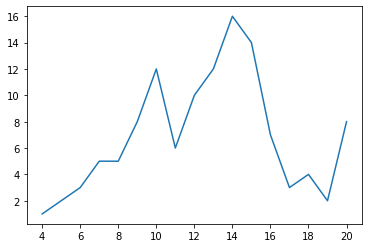

In [18]:
#finally time to plot something
import matplotlib.pyplot as plt

lists = sorted(starsDict.items()) # sorted by key, return a list of tuples
lists2 = sorted(numberDict.items())

x, y = zip(*lists) # unpack a list of pairs into two tuples
quarters, number_of_films = zip(*lists2)

%matplotlib inline
plt.plot(quarters, number_of_films)
plt.show()

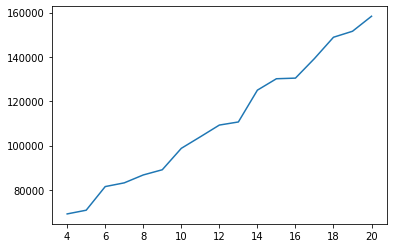

In [19]:
#Now I can import the Netflix Subscriber Data (taken from various financial filings)

z=[69168,70839,81500,83177,86743,89090,98748,103952,109248,110644,124995,130141,130422,139259,148863,151562,158334]
%matplotlib inline
plt.plot(x, z)
plt.show()